In [1]:
from Scripts.essentials import *

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4005908115893433186
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5835325440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10759197226217523463
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Load the models

In [2]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")
ensemble_model.summary()

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")
standard_model.summary()

# Cascaded model
cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")
cascade.summary()

import WahlModel
wahl_model = WahlModel.load_model()
wahl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 custom_pad (CustomPad)         (None, None, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 10)     1290        ['custom_pad[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 10)    40          ['conv1d[0][0]']                 
 alization)                                                                                   

In [3]:
import sklearn.metrics as metrics

def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

d_path = "data/Generated_data/"
datasets = [
            (d_path+"X_1024_10_300.npy", d_path+"y_peaks_1024_10_300.npy"),
           ]
metrics_dict = {}
full_metrics_dict = {}

for data in datasets:

    # Load the dataset we want to evaluate
    X = np.load(data[0])
    target = np.load(data[1])

    ## DL-predictions ##
    # Standard model
    standard_preds = standard_model.predict(X, verbose = 0)
    # Get the peaks
    standard_preds = standard_preds[-1]
    
    # Retrained model predictions
    ensemble_preds = ensemble_model.predict(X, verbose = 0)
    # Get the peaks
    ensemble_preds = ensemble_preds[-1]
    
    # Cascaded preds, multiply X by 1000 to set the required input shape
    cascaded_preds = cascade.predict(X * 1000, verbose = 0)
    # Get peaks
    cascaded_preds = np.squeeze(cascaded_preds[-1]/1000)
    
    # The suggested way to preprocess our data for Wahls model
    # Wahl preds
    
    wahl_mean = np.expand_dims(np.mean(np.squeeze(X), axis = 1), -1)
    wahl_norm = np.expand_dims(np.linalg.norm(np.squeeze(X), axis = 1), -1)
    wahl_prep = 256 * (np.squeeze(X) - wahl_mean)/wahl_norm
    wahl_prep = np.expand_dims(wahl_prep, -1)
    
    # Get the Wahl predictions
    wahl_preds = np.nan_to_num(wahl_model.predict(wahl_prep))


    method_preds = [ensemble_preds, standard_preds, cascaded_preds, wahl_preds]
    method_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Wahl"]

        # Gather the metrics
    metrics_dict[data[0]] = {}
    full_metrics_dict[data[0]] = {}
    for preds, name in zip(method_preds, method_names):
        
        print(name)
        
        # Get metric independently for every spectrum
        if name == "Wahl":
            RMSE_metrics = []
            MaxError_metrics = []
            for spec, p in zip(np.nan_to_num(normalize(target)), np.nan_to_num(normalize(np.squeeze(preds)))):
                RMSE_metrics.append(root_mean_squared_error(p, spec)) # I defined the metrics with true, pred order...
                MaxError_metrics.append(metrics.max_error(spec, p))
        else:
            RMSE_metrics = []
            MaxError_metrics = []
            for spec, p in zip(target, np.squeeze(preds)):
                RMSE_metrics.append(root_mean_squared_error(p, spec)) # I defined the metrics with true, pred order...
                MaxError_metrics.append(metrics.max_error(spec, p))
        
        print("\tRMSE:",
              "\n\t\tMean:", np.round(np.mean(RMSE_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(RMSE_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(RMSE_metrics), 2))

        print("\tMax error:",
              "\n\t\tMean:", np.round(np.mean(MaxError_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(MaxError_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(MaxError_metrics), 2))
    

        metrics_dict[data[0]][name] = [np.mean(RMSE_metrics), np.median(RMSE_metrics), np.var(RMSE_metrics),
                                       np.mean(MaxError_metrics), np.median(MaxError_metrics),
                                       np.var(MaxError_metrics)]

        full_metrics_dict[data[0]][name] = [np.array(RMSE_metrics), np.array(MaxError_metrics)]
        
        # We will save some figures of where the models struggle in a unique folder
    path = "Figures/"+ data[1].split("/")[-1]
    if not os.path.exists(path):
        os.mkdir(path)


  1/313 [..............................] - ETA: 35s

C:\Users\jesjob\AppData\Local\Temp\ipykernel_15192\803805384.py:40: RuntimeWarning: invalid value encountered in divide
  wahl_prep = 256 * (np.squeeze(X) - wahl_mean)/wahl_norm


313/313 [==============================] - 1s 4ms/step
Ensemble
	RMSE: 
		Mean: 0.02 
		Median: 0.02 
		Variance: 0.0
	Max error: 
		Mean: 0.1 
		Median: 0.09 
		Variance: 0.01
Standard
	RMSE: 
		Mean: 0.02 
		Median: 0.02 
		Variance: 0.0
	Max error: 
		Mean: 0.09 
		Median: 0.09 
		Variance: 0.0
Kazemzadeh et al.
	RMSE: 
		Mean: 0.04 
		Median: 0.03 
		Variance: 0.0
	Max error: 
		Mean: 0.15 
		Median: 0.14 
		Variance: 0.01
Wahl


C:\Users\jesjob\Desktop\Projects\SpectrumCorrectionFinal\Scripts\essentials.py:77: RuntimeWarning: invalid value encountered in divide
  return (x-min_)/(max_-min_)


	RMSE: 
		Mean: 0.18 
		Median: 0.18 
		Variance: 0.01
	Max error: 
		Mean: 0.71 
		Median: 0.76 
		Variance: 0.07


In [4]:
path = "Data/Outputs/P/"
for data_name in full_metrics_dict.keys():
    for model_name in full_metrics_dict[data_name].keys():
        data = full_metrics_dict[data_name][model_name]

        np.save(path + model_name + ".np", data)

In [5]:
header = ["RMSE:mean", "RMSE:median", "RMSE:variance", "MaxError:mean", "MaxError:median", "MaxError:variance"]

with pd.ExcelWriter('Results/PeakComparisons.xlsx') as writer:
    for key in metrics_dict.keys():

        df = pd.DataFrame.from_dict(metrics_dict[key],
                                        columns = header,
                                        orient = "index")
        filename = key.split("/")[1] + key.split("/")[2]
        df = df.round(decimals = 2).drop(columns=["RMSE:median", "MaxError:median"])
        df.to_excel(writer, sheet_name=filename)
        
        print(key)
        df = df.style.format(decimal=',', thousands='.', precision = 2)
        print(df.to_latex())

data/Generated_data/X_1024_10_300.npy
\begin{tabular}{lrrrr}
 & RMSE:mean & RMSE:variance & MaxError:mean & MaxError:variance \\
Ensemble & 0,02 & 0,00 & 0,10 & 0,01 \\
Standard & 0,02 & 0,00 & 0,09 & 0,00 \\
Kazemzadeh et al. & 0,04 & 0,00 & 0,15 & 0,01 \\
Wahl & 0,18 & 0,01 & 0,71 & 0,07 \\
\end{tabular}



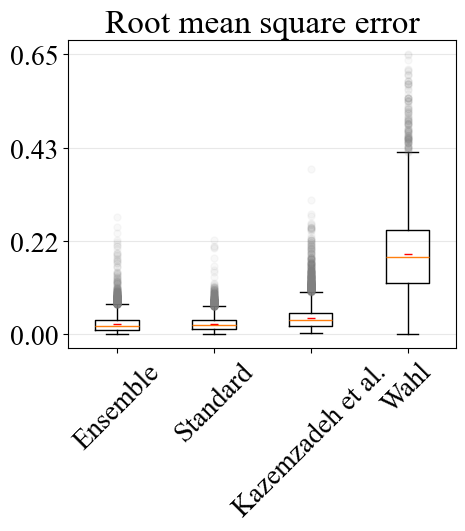

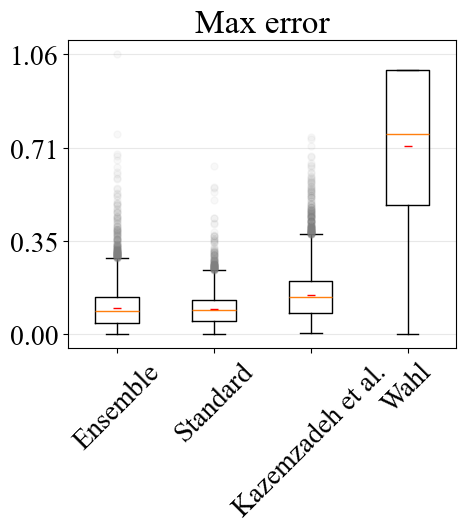

In [6]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "Times New Roman"
dimension = (5, 4)
num_ticks = 4
for key in full_metrics_dict.keys():

    key2 = list(full_metrics_dict[key].keys())


    # RMSE metrics
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}
    
    model_metrics = [full_metrics_dict[key][k][0] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
                 )

    
    ax.set_title("Root mean square error")
    max_ = np.max([full_metrics_dict[key][k][0] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/P_RMSE.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()
    
    
    # Max error metrics
    model_metrics = [full_metrics_dict[key][k][1] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                 showmeans=True,
                  flierprops = flier_props,
                  meanprops= mean_props,
                 #showfliers=False,
                 )
    ax.set_title("Max error")
    max_ = np.max([full_metrics_dict[key][k][1] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/P_MaxError.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()

In [7]:
# Load the Wahl validation set
d_path = "data/Generated_data/"
aval = np.loadtxt("data/WahlData/Aval.csv",
                 delimiter=",", dtype=np.float32)

dval = np.loadtxt("data/WahlData/Dval.csv",
                 delimiter=",", dtype=np.float32)

aval_reshape = aval.reshape(-1, 1024)
dval_reshape = dval.T

# Reshape and normalize the data for the other models
data = np.copy(dval_reshape)
data = normalize(data)   

target = np.copy(aval_reshape)
target = normalize(target)

In [8]:
wahl_preds = wahl_model.predict(np.expand_dims(np.expand_dims(dval_reshape, -1), -1))

2458/2458 [==============================] - 10s 4ms/step


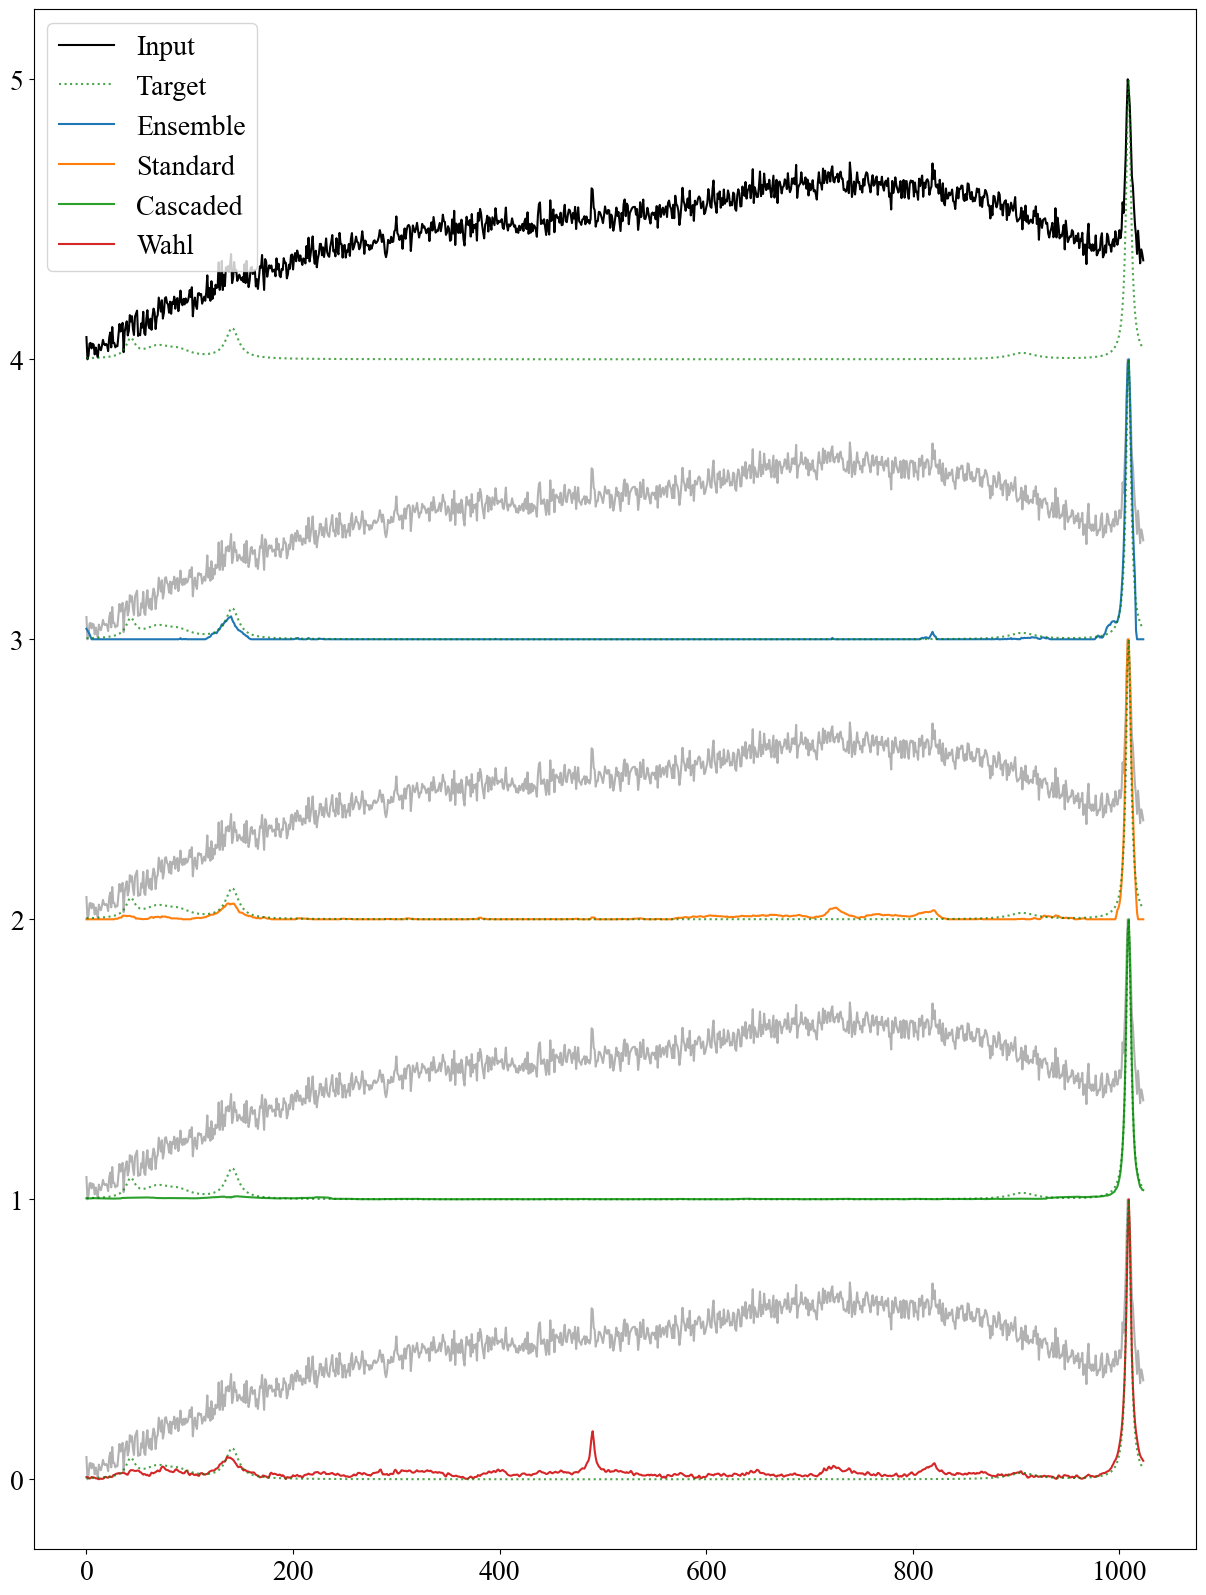

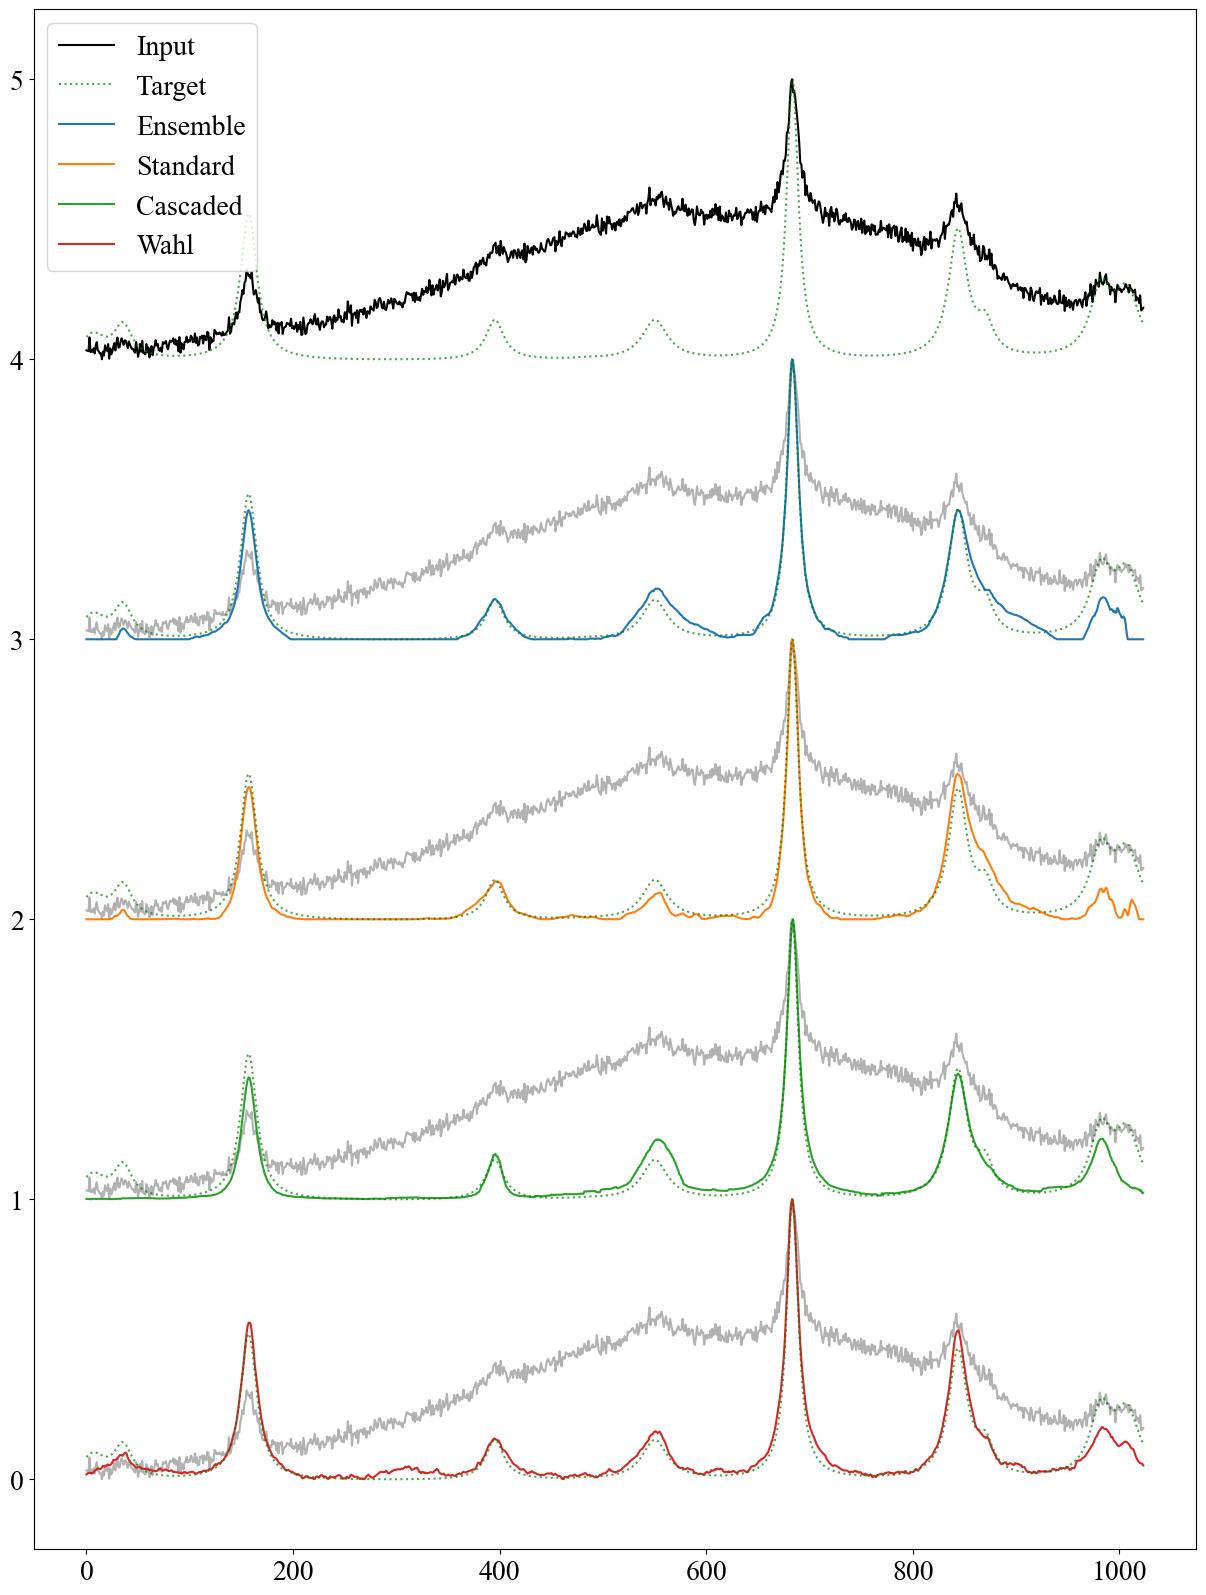

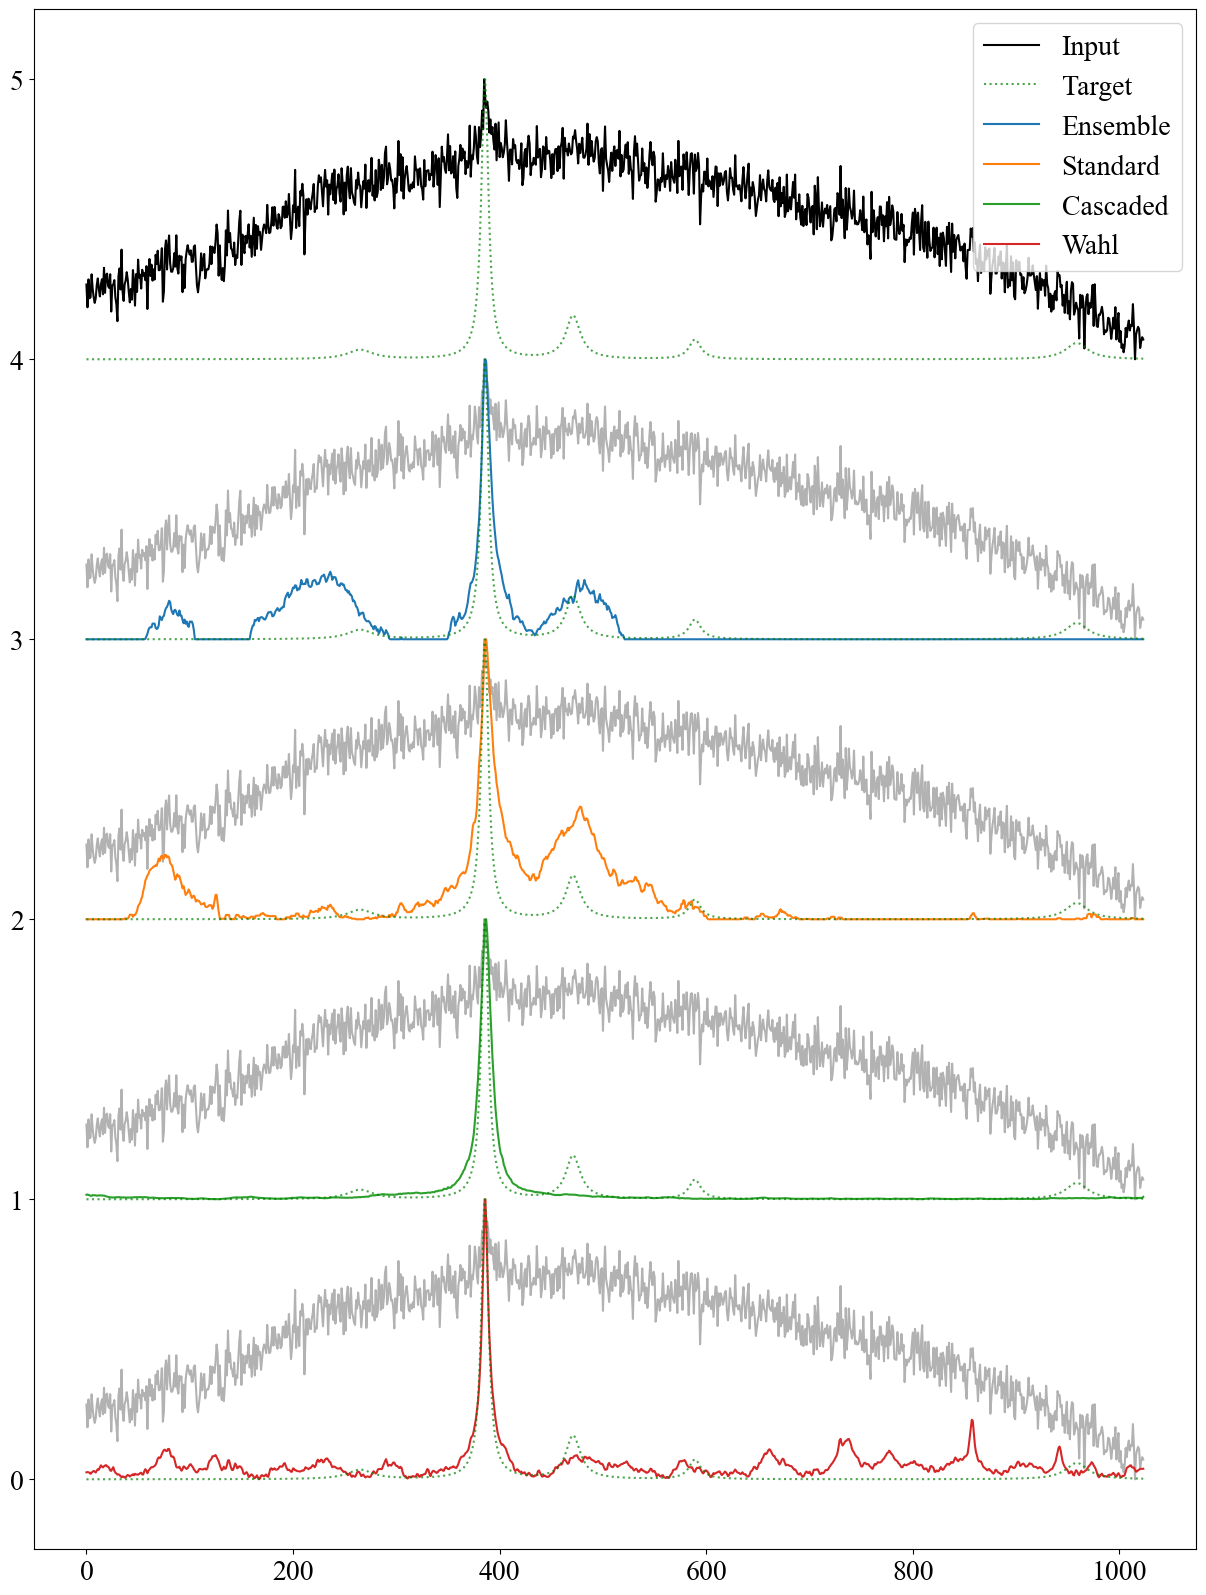

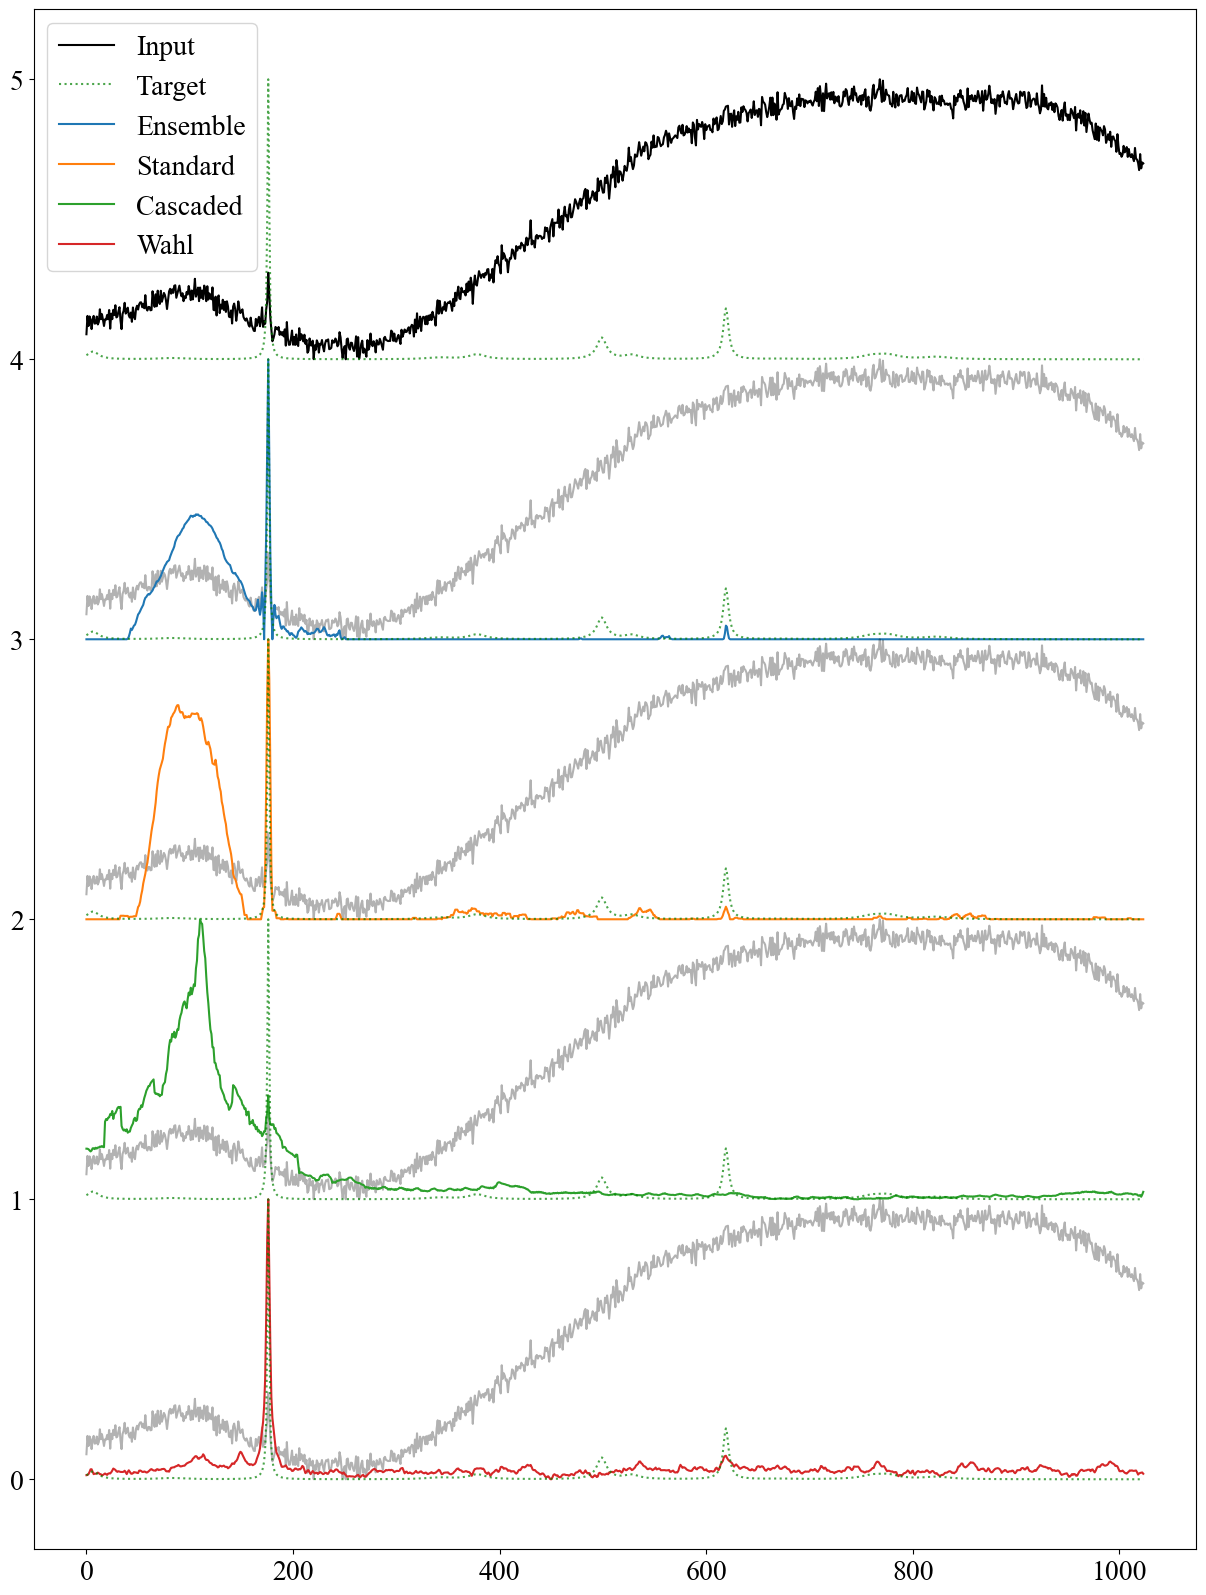

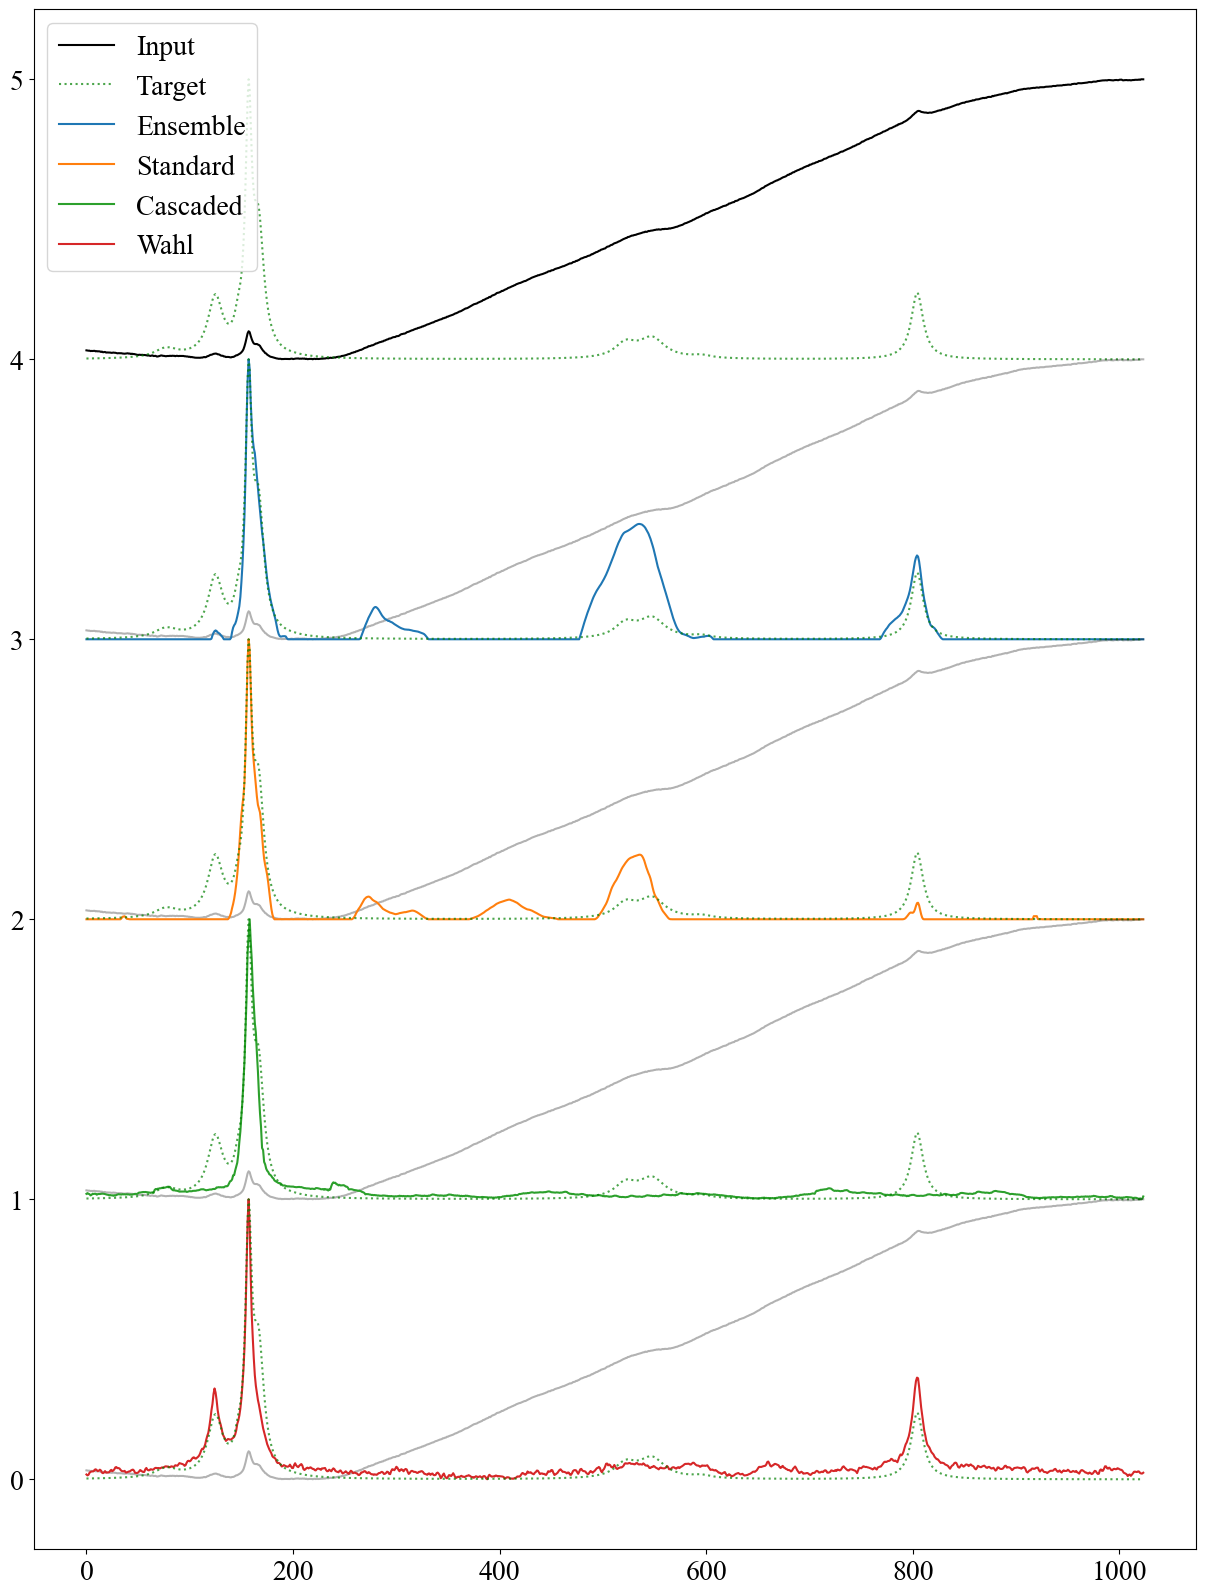

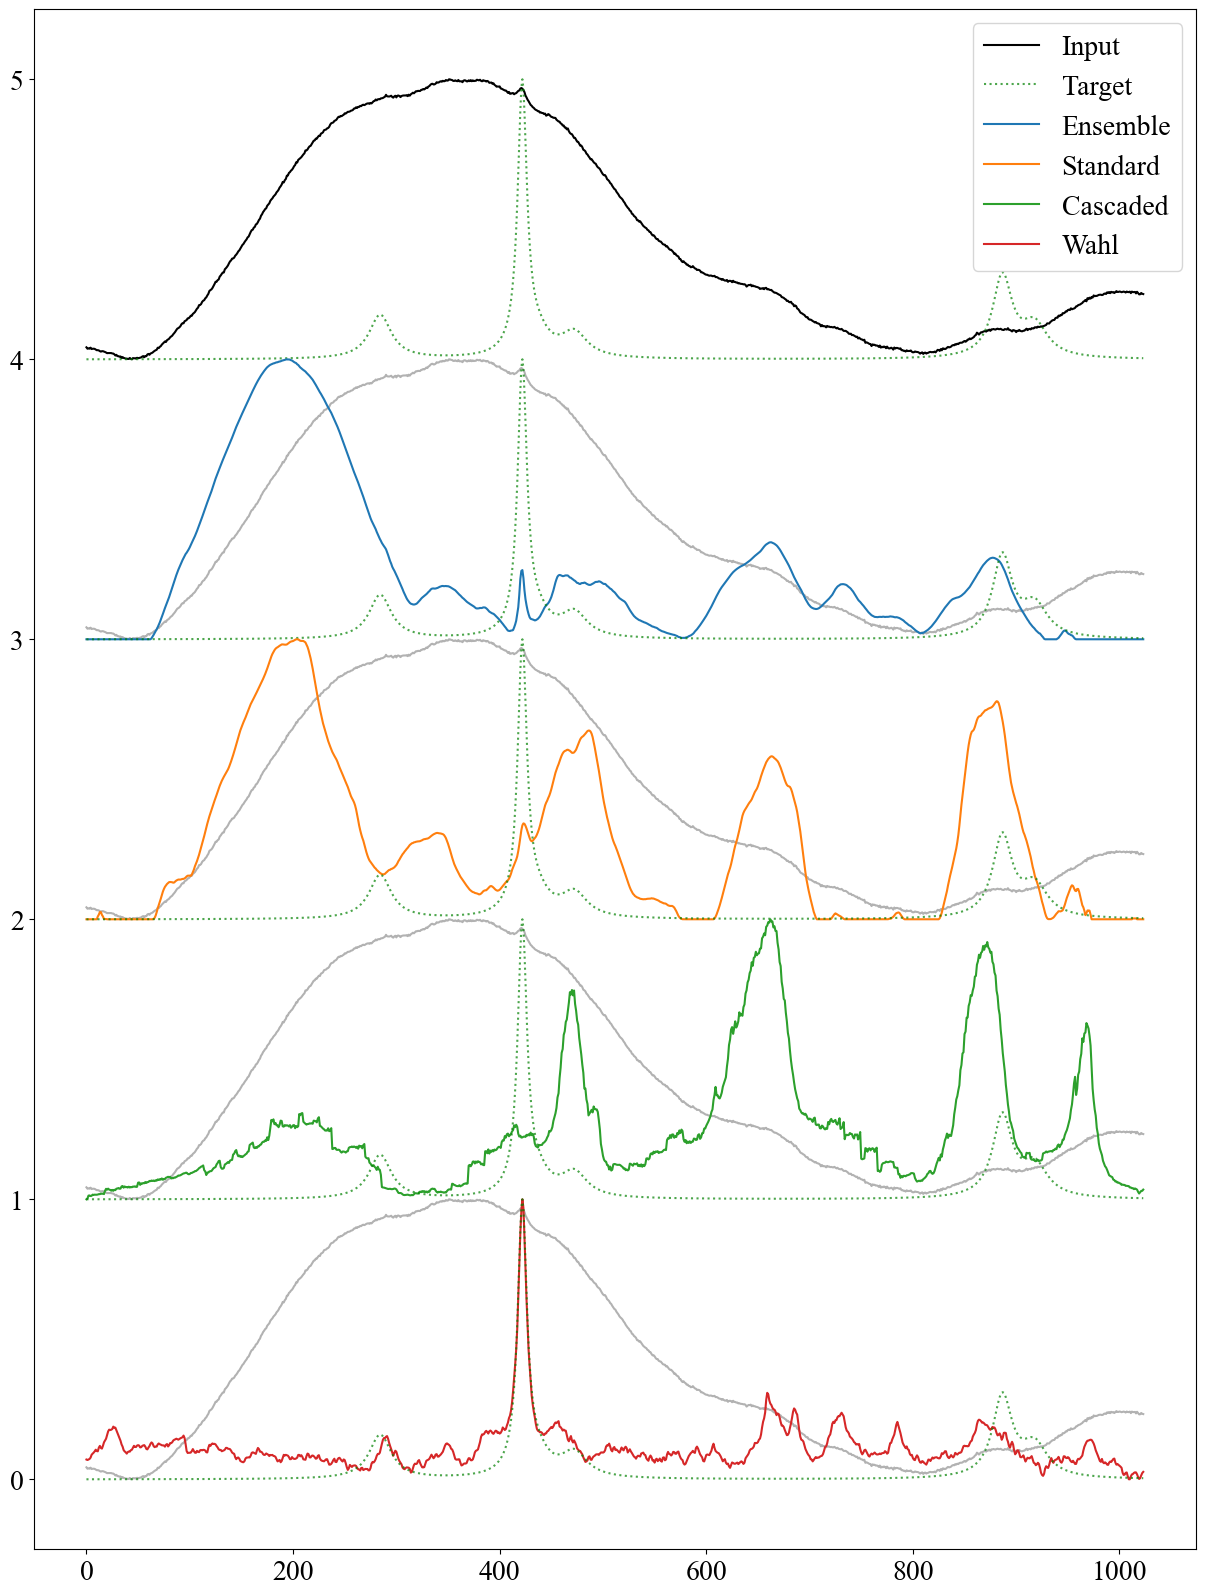

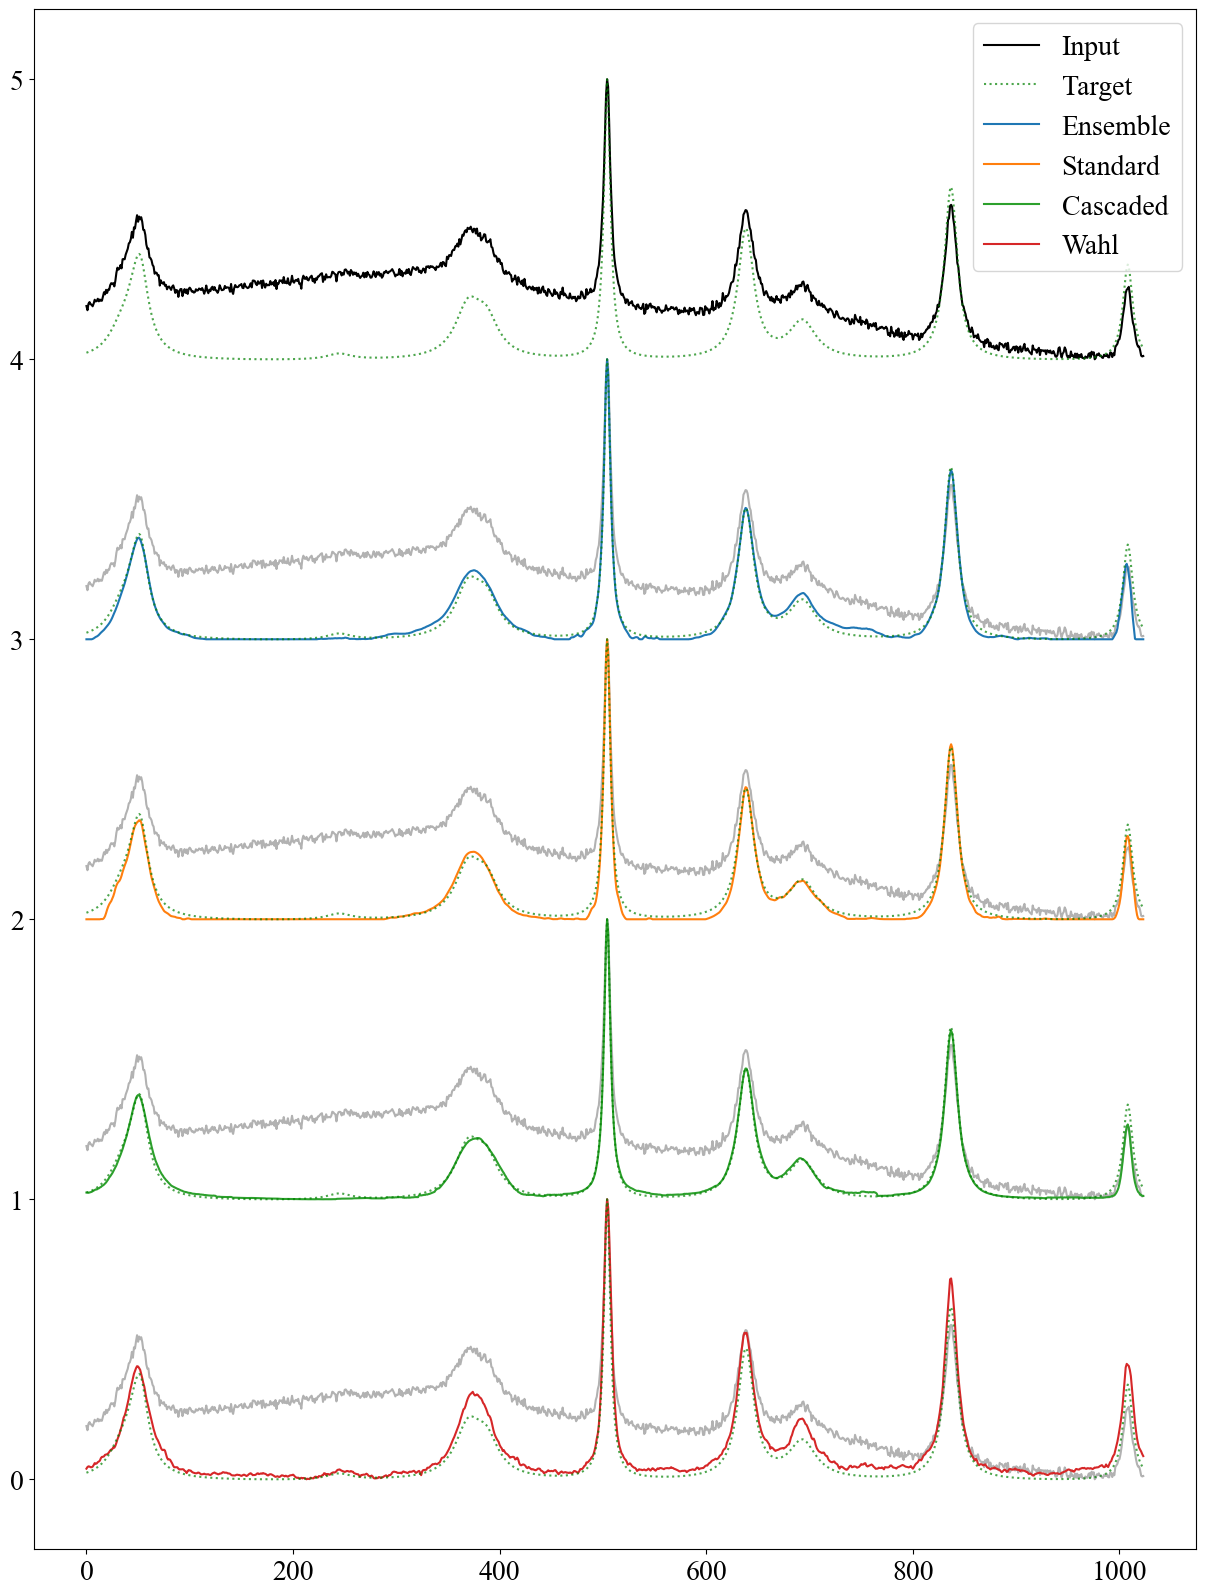

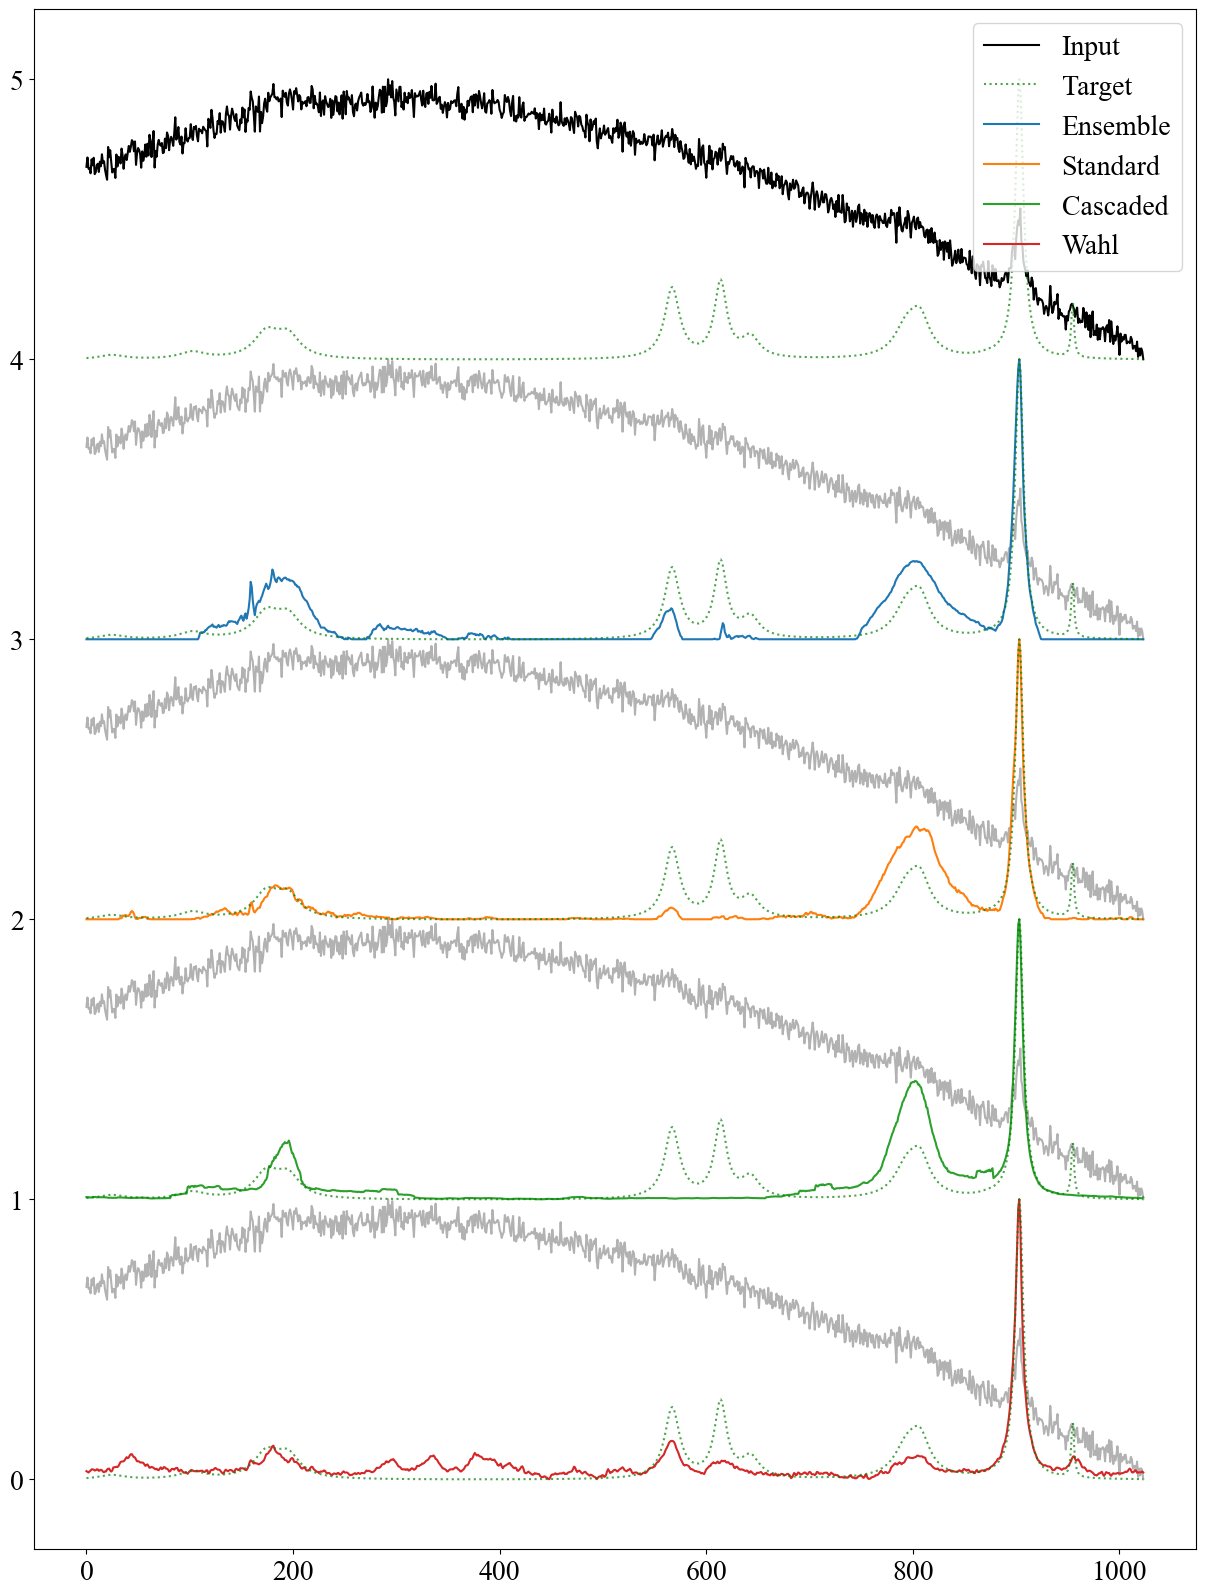

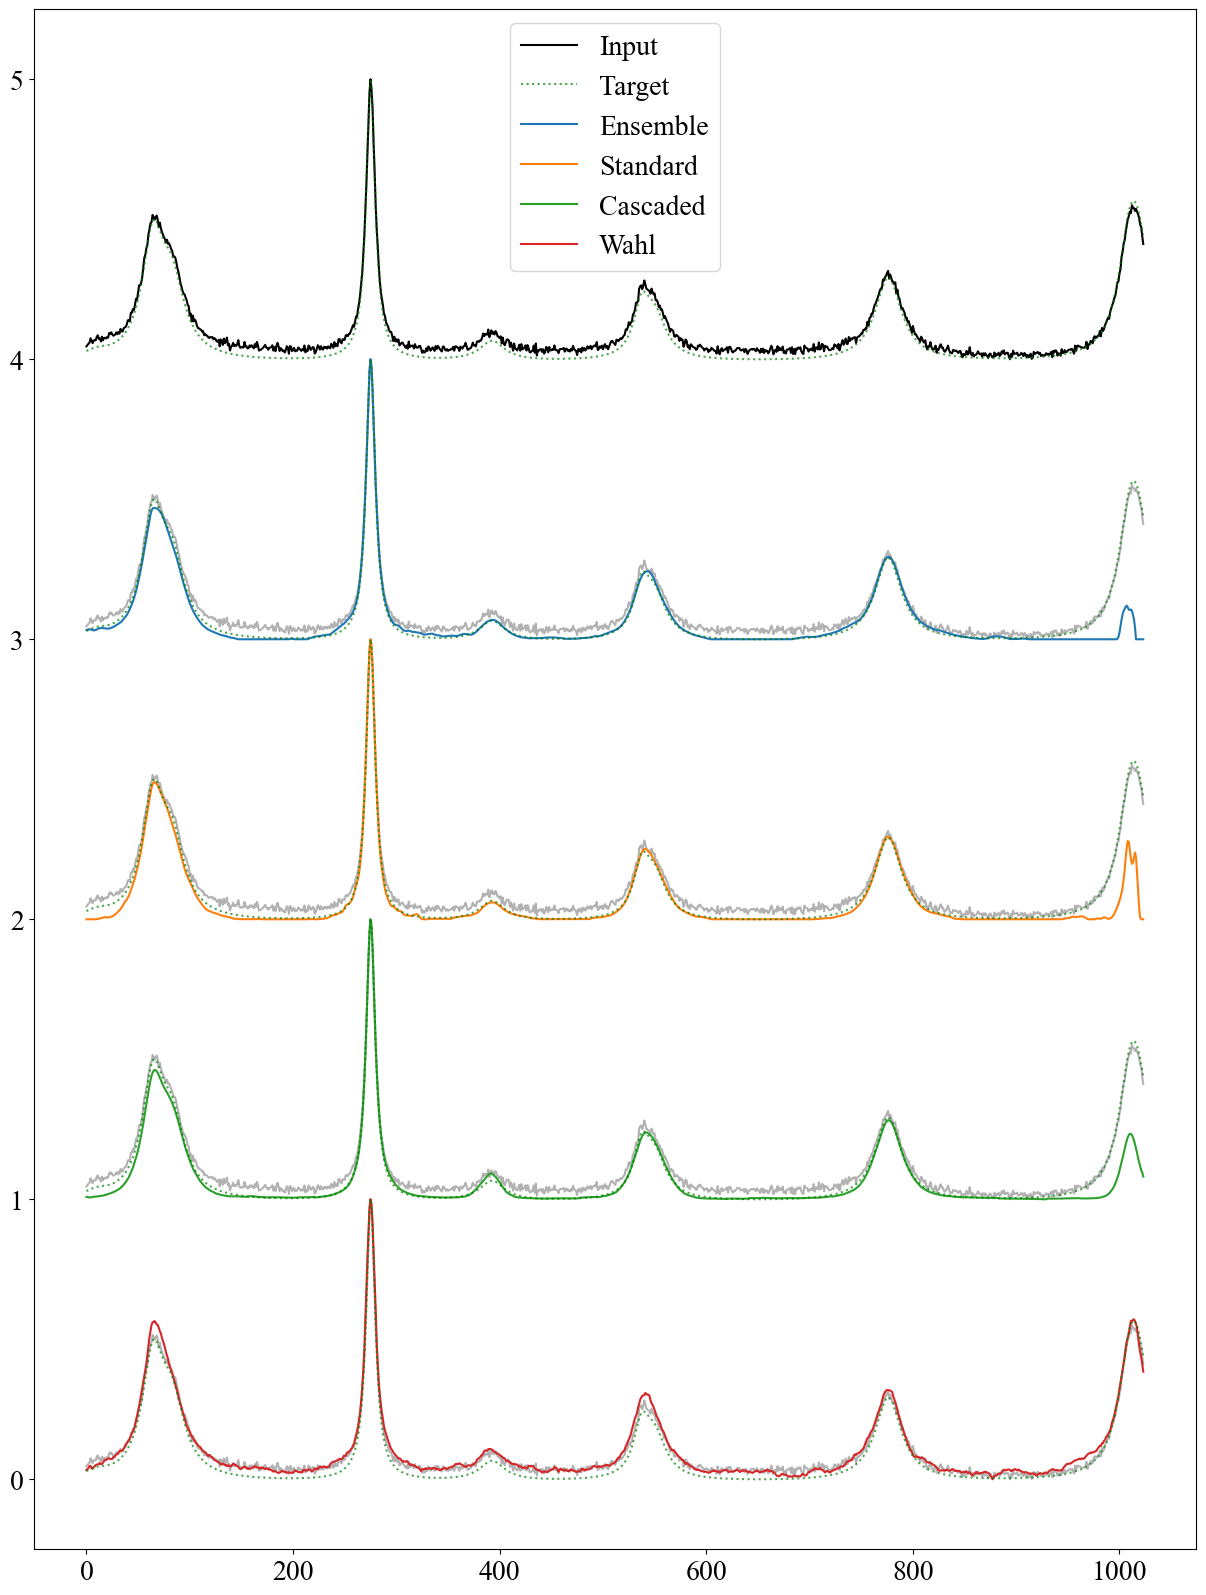

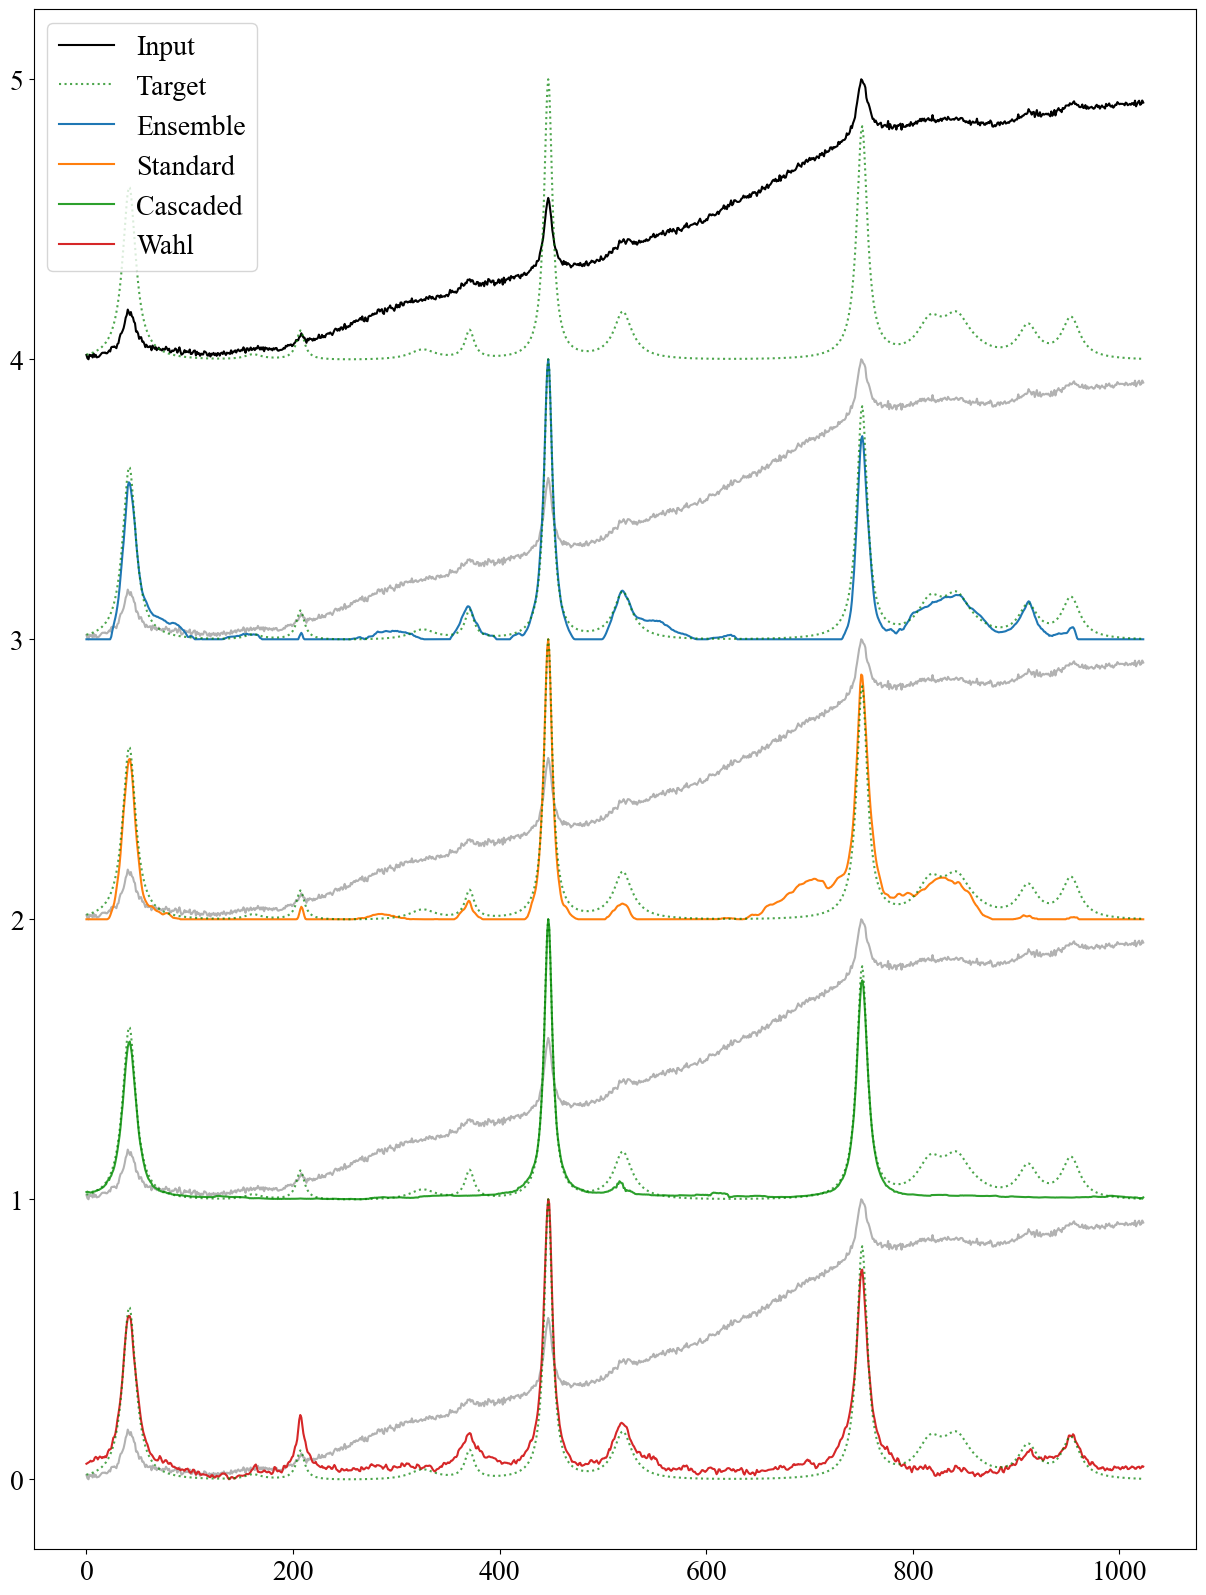

In [9]:

metrics_dict = {}
full_metrics_dict = {}
for data_name in ["/WahlComparison"]:
    
    X = np.expand_dims(data, -1)
    ## DL-predictions ##
    # Standard model
    standard_preds = standard_model.predict(X, verbose = 0)
    # Get the peaks
    standard_preds = standard_preds[-1]
    
    # Retrained model predictions
    ensemble_preds = ensemble_model.predict(X, verbose = 0)
    # Get the peaks
    ensemble_preds = ensemble_preds[-1]
    
    # Cascaded preds, multiply X by 1000 to set the required input shape
    cascaded_preds = cascade.predict(X * 1000, verbose = 0)
    # Get baselines, by subtracting the baseline corrected spectrum
    cascaded_preds = np.squeeze(cascaded_preds[-1]/1000)

    # Wahl preds are computed independently above
    
    method_preds = [ensemble_preds, standard_preds, cascaded_preds, wahl_preds]
    method_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Wahl"]

    # Save the figures in a unique folder for potential use later
    path = "Figures/"+ data_name.split("/")[-1] + "WahlData"
    if not os.path.exists(path):
        os.mkdir(path)
    
    for spec_ix in range(10): 
        plt.figure(figsize=(15, 20))
        plt.plot(normalize_1D(X[spec_ix])+len(method_preds), label = "Input", color = "Black")
        plt.plot(normalize_1D(target[spec_ix])+len(method_preds), label = "Target",
                 color = "Green", ls=":", alpha = 0.7)
        
        for i in range(len(method_preds)):
            indent = len(method_preds) - i -1
    
            plt.plot(normalize_1D(X[spec_ix]) + indent, color = "Black", alpha = 0.3)
            plt.plot(normalize_1D(method_preds[i][spec_ix]) + indent, label = method_names[i])
            plt.plot(normalize_1D(target[spec_ix]) + indent, color = "Green", ls=":", alpha = 0.7)
    
        plt.legend()
        plt.savefig(path + "/" + str(spec_ix) + ".pdf", format="pdf",)
        plt.show()

In [11]:
# Gather the metrics
metrics_dict[data_name] = {}
full_metrics_dict[data_name] = {}
for preds, name in zip(method_preds, method_names):    
    print(name)

    RMSE_metrics = []
    MaxError_metrics = []
    for spec, p in zip(np.nan_to_num(normalize(target)), np.nan_to_num(normalize(np.squeeze(preds)))):
        RMSE_metrics.append(root_mean_squared_error(p, spec)) # I defined the metrics with true, pred order...
        MaxError_metrics.append(metrics.max_error(spec, p))
                
            
        # Print statistics
    print("\tRMSE:",
              "\n\t\tMean:", np.round(np.mean(RMSE_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(RMSE_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(RMSE_metrics), 2))

    print("\tMax error:",
              "\n\t\tMean:", np.round(np.mean(MaxError_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(MaxError_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(MaxError_metrics), 2))
    
    
    metrics_dict[data_name][name] = [np.mean(RMSE_metrics), np.median(RMSE_metrics), np.var(RMSE_metrics),
                                     np.mean(MaxError_metrics), np.median(MaxError_metrics),
                                       np.var(MaxError_metrics)]

    full_metrics_dict[data_name][name] = [np.array(RMSE_metrics), np.array(MaxError_metrics)]
                                     

Ensemble


C:\Users\jesjob\Desktop\Projects\SpectrumCorrectionFinal\Scripts\essentials.py:77: RuntimeWarning: invalid value encountered in divide
  return (x-min_)/(max_-min_)


	RMSE: 
		Mean: 0.06 
		Median: 0.03 
		Variance: 0.01
	Max error: 
		Mean: 0.23 
		Median: 0.12 
		Variance: 0.06
Standard
	RMSE: 
		Mean: 0.06 
		Median: 0.03 
		Variance: 0.01
	Max error: 
		Mean: 0.27 
		Median: 0.15 
		Variance: 0.07
Cascaded
	RMSE: 
		Mean: 0.06 
		Median: 0.02 
		Variance: 0.01
	Max error: 
		Mean: 0.24 
		Median: 0.12 
		Variance: 0.08
Wahl
	RMSE: 
		Mean: 0.04 
		Median: 0.03 
		Variance: 0.0
	Max error: 
		Mean: 0.18 
		Median: 0.13 
		Variance: 0.02


In [14]:
path = "Data/Outputs/WahlP/"
for data_name in full_metrics_dict.keys():
    for model_name in full_metrics_dict[data_name].keys():
        data = full_metrics_dict[data_name][model_name]

        np.save(path + model_name + ".np", data)

In [15]:
header = ["RMSE:mean", "RMSE:median", "RMSE:variance", "MaxError:mean", "MaxError:median", "MaxError:variance"]

print(metrics_dict.keys())
with pd.ExcelWriter('Results/PeakComparisons(WahlData).xlsx') as writer:
    for key in metrics_dict.keys():

        df = pd.DataFrame.from_dict(metrics_dict[key],
                                        columns = header,
                                        orient = "index")
        filename = "WahlData"
        df = df.round(decimals = 2).drop(columns=["RMSE:median", "MaxError:median"])
        df.to_excel(writer, sheet_name=filename)
        
        print()
        df = df.style.format(decimal=',', thousands='.', precision=2)
        print(df.to_latex())

dict_keys(['/WahlComparison'])

\begin{tabular}{lrrrr}
 & RMSE:mean & RMSE:variance & MaxError:mean & MaxError:variance \\
Ensemble & 0,06 & 0,01 & 0,23 & 0,06 \\
Standard & 0,06 & 0,01 & 0,27 & 0,07 \\
Cascaded & 0,06 & 0,01 & 0,24 & 0,08 \\
Wahl & 0,04 & 0,00 & 0,18 & 0,02 \\
\end{tabular}



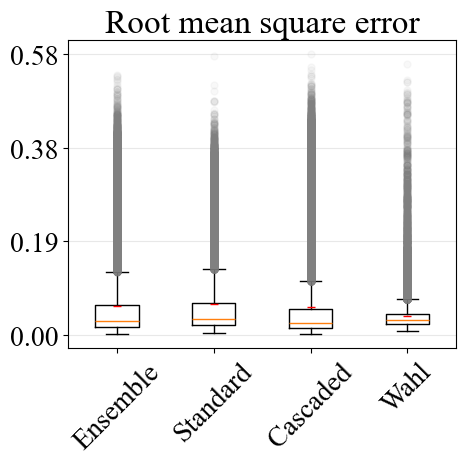

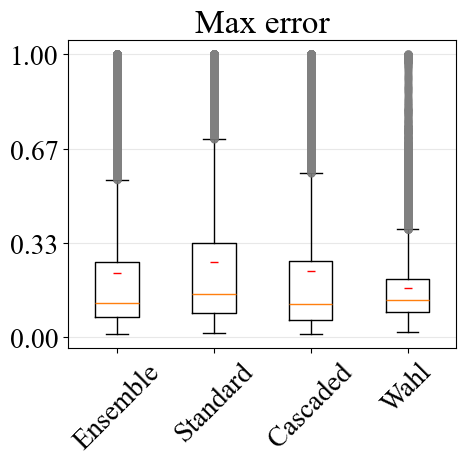

In [16]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "Times New Roman"
dimension = (5, 4)
num_ticks = 4
for key in full_metrics_dict.keys():

    key2 = list(full_metrics_dict[key].keys())


    # RMSE metrics
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}
    
    model_metrics = [full_metrics_dict[key][k][0] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
                 )

    
    ax.set_title("Root mean square error")
    max_ = np.max([full_metrics_dict[key][k][0] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/WahlP_RMSE.tiff",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()
    
    
    # Max error metrics
    model_metrics = [full_metrics_dict[key][k][1] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                 showmeans=True,
                  flierprops = flier_props,
                  meanprops= mean_props,
                 #showfliers=False,
                 )
    ax.set_title("Max error")
    max_ = np.max([full_metrics_dict[key][k][1] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/WahlP_MaxError.pdf", format="pdf",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()